In [1]:
import cv2
import numpy as np
import mediapipe as mp
import joblib
import os
import math
import matplotlib.pyplot as plt

In [2]:
MODEL_DIR = 'model'
IMAGE_PATH = 'AFLW2000/image00013.jpg'

In [3]:
def create_feature_vector(face_landmarks):
    anchor_point = face_landmarks.landmark[1]
    p_left = face_landmarks.landmark[359]
    p_right = face_landmarks.landmark[130]
    scale_distance = np.linalg.norm([p_left.x - p_right.x, p_left.y - p_right.y])
    if scale_distance < 1e-6:
        return None
    feature_vector = []
    for i in range(len(face_landmarks.landmark)):
        if i == 1: continue
        landmark = face_landmarks.landmark[i]
        feature_vector.extend([
            (landmark.x - anchor_point.x) / scale_distance,
            (landmark.y - anchor_point.y) / scale_distance,
            (landmark.z - anchor_point.z) / scale_distance
        ])
    return np.array(feature_vector)

In [4]:
def draw_axes(img, pitch, yaw, roll, nose_2d, size=100):
    pitch = pitch * np.pi / 180
    yaw = -(yaw * np.pi / 180)
    roll = roll * np.pi / 180
    Rx = np.array([[1, 0, 0], [0, math.cos(pitch), -math.sin(pitch)], [0, math.sin(pitch), math.cos(pitch)]])
    Ry = np.array([[math.cos(yaw), 0, math.sin(yaw)], [0, 1, 0], [-math.sin(yaw), 0, math.cos(yaw)]])
    Rz = np.array([[math.cos(roll), -math.sin(roll), 0], [math.sin(roll), math.cos(roll), 0], [0, 0, 1]])
    R = Rz @ Ry @ Rx
    axis = np.array([[size, 0, 0], [0, size, 0], [0, 0, size]])
    rotated_axis = R @ axis
    
    p1 = (int(nose_2d[0]), int(nose_2d[1]))
    # Sumbu Y (Pitch) - Hijau
    p2 = (int(nose_2d[0] + rotated_axis[0, 1]), int(nose_2d[1] + rotated_axis[1, 1]))
    cv2.line(img, p1, p2, (0, 255, 0), 3)
    # Sumbu X (Yaw) - Biru
    p2 = (int(nose_2d[0] + rotated_axis[0, 0]), int(nose_2d[1] + rotated_axis[1, 0]))
    cv2.line(img, p1, p2, (255, 0, 0), 3)
    # Sumbu Z (Roll) - Merah
    p2 = (int(nose_2d[0] + rotated_axis[0, 2]), int(nose_2d[1] + rotated_axis[1, 2]))
    cv2.line(img, p1, p2, (0, 0, 255), 3)
    return img

In [7]:
def test_single_image_notebook(model_paths, image_path):
    try:
        models = {
            'pitch': joblib.load(model_paths['pitch']),
            'yaw': joblib.load(model_paths['yaw']),
            'roll': joblib.load(model_paths['roll'])
        }
        print("Model berhasil dimuat.")
    except FileNotFoundError:
        print(f"Error: File model tidak ditemukan di '{MODEL_DIR}'.")
        return

    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Gagal memuat gambar dari '{image_path}'.")
        return
        
    mp_face_mesh = mp.solutions.face_mesh
    face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, min_detection_confidence=0.5, refine_landmarks=False)
    results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    
    if not results.multi_face_landmarks:
        print("Tidak ada wajah yang terdeteksi pada gambar.")
        # Tampilkan gambar asli jika tidak ada wajah terdeteksi
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title('Wajah Tidak Terdeteksi')
        plt.axis('off')
        plt.show()
        return

    for face_landmarks in results.multi_face_landmarks:
        feature_vector = create_feature_vector(face_landmarks)
        if feature_vector is not None:
            feature_vector = feature_vector.reshape(1, -1)
            
            pitch = models['pitch'].predict(feature_vector)[0]
            yaw = models['yaw'].predict(feature_vector)[0]
            roll = models['roll'].predict(feature_vector)[0]
            
            nose_2d = (face_landmarks.landmark[1].x * image.shape[1], face_landmarks.landmark[1].y * image.shape[0])
            image = draw_axes(image, pitch, yaw, roll, nose_2d)
            
            cv2.putText(image, f"Pitch: {pitch:.2f}", (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2)
            cv2.putText(image, f"Yaw: {yaw:.2f}", (20, 80), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2)
            cv2.putText(image, f"Roll: {roll:.2f}", (20, 120), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2)
            
    face_mesh.close()
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(8, 8))
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.title('Hasil Prediksi Head Pose')
    plt.show()

Model berhasil dimuat.


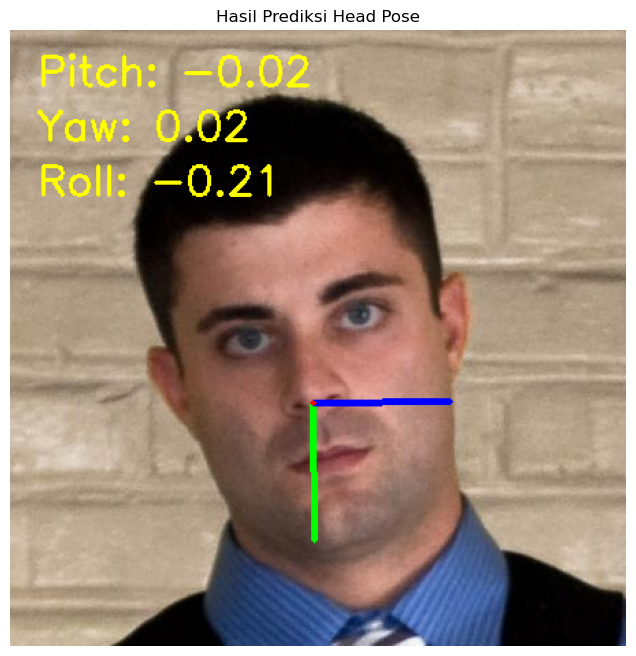

In [8]:
model_paths = {
    'pitch': os.path.join(MODEL_DIR, 'xgb_pitch_model.joblib'),
    'yaw': os.path.join(MODEL_DIR, 'xgb_yaw_model.joblib'),
    'roll': os.path.join(MODEL_DIR, 'xgb_roll_model.joblib')
}

test_single_image_notebook(model_paths, IMAGE_PATH)